# Drafting pipeline for downscaling LULUCF emissions

In [1]:
%%html
<style>
table {float:left}
</style>

Author: Firza Riany  
Email: firza.riany@climateanalytics.org  

Aim(s) of analysis:  
1. Downscaling emissions from regional to country level based on forest lost  
2. Downscaling sequestration based on the contribution of forest added to sequestration  
3. Downscaling net emissions based on the balance between downscaled emissions and sequestration  
4. Verifying the downscaling results  

Datasets:
- Model: `IMAGE`  
- Scenario: `SSP1_SPA0_19I_LIRE_LB`  

Variable | Data source  
:--- | :-------  
Land distribution map | `GLANDCOVER_30MIN.NC`
Cell size (to convert the distribution map to area in km2) | `GAREA_30M.asc`
World border | `TM_WORLD_BORDERS-0`
Regional emission profile | `SSP1_SPA0_19I_LIRE_LB.xlsx`; release June 2021

Description:  
The script prepares a downscaling pipeline to downscale gross emissions, sequestration, and net emissions from region to country-level. At the end of the script, the pipeline is run through a list of priorities countries. The result is exported to IAM format.

`LULUCF downscaling is based on the rate of forest area changes.`
It comes from IMAGE model assumptions that deforestation and forest growth are the main drivers for LULUCF emissions and sequestration. Forest area changes are calculated at each time step (from 2005 to 2100) by calculating the difference of forest ratio between two years. 

- The difference of forest ratio is done on cell-by-cell basis
- When the difference is negative, it is considered as forest lost (or deforestation)
- When the difference is positive, it is considered as forest growth (herein called forest added)

`After getting the timeseries of forest lost and added, ratio for downscaling is calculated.`
Ratio to downscale gross emissions is based on the country share of forest lost relative to the lost at the macro-region level. 

Ratio to downscale sequestration is based on the country share of forest sequestration relative to that at the macro-region level. Forest sequestration is estimated at every ages of growing and living forests based on the age-relevant sequestration rate. 

At every year, the age of new forest is determined then its sequestration at the given age is calculated. We only consider living forests as the input to estimate forest-based sequestration, so whenever there is a forest lost happening along the period of 2005 - 2100 in the same area as the occurrence of forest added, we use the forest lost to factor the forest added in the prior years. 

Sequestration rate at different forest ages is constructed as follows:
- In the first few years (20 - 25 years), forest sequesters carbon gradually until it reaches maximum at age 20 or 25 years 
- Forest will keep sequestering at the maximum rate for the next 60 - 100 years. Maximum seq rate and this "stable" period may vary depending on forest ecosystem.
- In the last few years when trees are getting older, forest deteriorates its seq rate until it reaches the minimum. This period goes for 25 - 30 years

Net emissions is downscaled based on the balance between gross emissions and sequestration.

In [2]:
# libraries

## data wraggling
import os
import copy
import pandas as pd
import numpy as np
import xarray as xr
import pyam

## geospatial data wraggling
import geopandas as gpd
import rioxarray

## plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme(style="dark")
%matplotlib inline

## built-in functions stored in ems_pattern_fun.py
from ems_pattern_fun import land_dist, land_area_clipped, land_area_changes, get_ratio, downscale_ems_seq 
from ems_pattern_fun import downscale_netemis, land_area_df, timeseries_df, pure_emis

<IPython.core.display.Javascript object>

## Working directory 
Function to get the directory of the data files. Data are stored in a gitlab repo, it is a pre-requisite to pull the repo to the local machine before running the script.  
The function will get the git directory of the data files in the user's machine.

In [3]:
os.getcwd()

'/Users/firzariany/1o5_pathways_land_use/scripts/exploration'

In [4]:
def get_data_path(give_additional_path=None):
    # when the git is sitting in /Users/user_name
    if give_additional_path==None:
        my_path = os.path.join(os.path.expanduser('~'), "1o5_pathways_land_use", "data")
        
    # when the git is sitting in /Users/user_name/Documents/more/file/directory/...
    else:
        my_path = os.path.join(os.path.expanduser('~') + give_additional_path)
    
    return my_path

`Test: when git is stored in /Users/user_name, use the default parameter of the function`

In [5]:
print("Current working directory:", os.getcwd())

Current working directory: /Users/firzariany/1o5_pathways_land_use/scripts/exploration


In [6]:
my_data_path = get_data_path()

In [7]:
print("Get the path to the data files with default settings:", my_data_path)
print("Does it exist in my computer?", os.path.exists(my_data_path))

Get the path to the data files with default settings: /Users/firzariany/1o5_pathways_land_use/data
Does it exist in my computer? True


`Test: when git is stored in a specified folder /Users/user_name/Documents... specify the folder location after /Users/user_name towards the data folder in git`

In [8]:
# when git is sitting somewhere else
## in the parameter: should start with "/" for mac
## or with "\\" for windows, check your machine convention
my_data_path_somewhere = get_data_path(give_additional_path="/Documents/ikea_land_use/1o5_pathways_land_use/data") 

In [9]:
print("Get the path to the data files by providing additional parameter:", my_data_path_somewhere)
print("Does it exist in my computer?", os.path.exists(my_data_path_somewhere))

Get the path to the data files by providing additional parameter: /Users/firzariany/Documents/ikea_land_use/1o5_pathways_land_use/data
Does it exist in my computer? False


## IMAGE dataset
Primarily used to get forest area, regional borders, and country borders

In [10]:
# data path = either my_data_path or my_data_path_somewhere, set your data path using get_data_path()
image_file = "/IMAGE_SSPs/SSP1s_july2021/SSP1_SPA0_19I_LIRE_LB/GLANDCOVER_30MIN.NC"

df_19 = xr.open_dataset(my_data_path+image_file)
df_19 = df_19.rio.write_crs(4326)

In [11]:
# select land cover variable
glandcov_19 = df_19.GLANDCOVER_30MIN

# convert the current datetime type to only year type
glandcov_19["time"] = pd.DatetimeIndex(glandcov_19.time).year

In [12]:
# world border
b_file = "/IMAGE_SSPs/TM_WORLD_BORDERS-0"

regions = gpd.read_file(my_data_path+b_file)

In [13]:
# import garea, cell size
garea_file = "/IMAGE_SSPs/GAREA_30M.asc"

area = (rioxarray.open_rasterio(my_data_path+garea_file))
area_to_use = area.rio.write_crs(4326)

## Emission dataset
Storing regional emissions from global pathways with SSP1, maintaining global warming at RCP1.9, low biomass input, and high renewable energy

In [14]:
# emission data SSP1_SPA0, still sourcing xlsx
file_tab = "/IMAGE_SSPs_tabular_data/Release_June2021/SSP1_SPA0_19I_LIRE_LB.xlsx"

df_tab = pd.read_excel(my_data_path+file_tab, sheet_name="data")

# Calculate forest area changes and forest sequestration
The function calculates the rate of forest changes then the forest sequestration.

It takes forest ration and calculate the differences between two years for a period of 2005 - 2100. When the difference is larger than 0 then there's new forest added. When the difference is lower than 0 then there's forest lost. The cells with forest added and lost are summed and multiplied with cell size to get their total land area. The balance between forest lost and added is calculated as net change for every year.  

Total land area of forest added is an input to estimate forest sequestration. Only living forests that will be considered to actively sequestering carbon, hence at every year iteration, forest added is factored by forest lost. Then forest sequestration is estimated based on the sequestration rate at a given year.

The function returns a dataframe that stores the amount of forest lost, forest added, the net change, and forest sequestration indexed by years.

The function takes the following parameters:  

Parameter | Description  
:--- | :-------  
`input_ncdf` | the NetCDF, object-like, N-dimensions data array type storing the land probability distribution map
`give_land_type` | str type, the variable name of the concerned land use type within the NetCDF file (i.e. for forest is b'forest)
`reg_boundary` | an object-like, geo dataframe storing the country borders. To be used to mask ncdf_input and area_input to country or regional borders
`area_input` | raster, object-like, data array type storing the size of the cells
`seq_rate_ls` | array, list, series type storing sequestration rate of trees at different ages

In [15]:
# function to mask forest distribution area to COD borders
def masked_forest_ratio(ncdf, land_type, reg_name, **kwargs):
    dist_df = ncdf.sel(NGLNDCOV = land_type, **kwargs)
    
    reg = reg_name
    g_reg = reg.geometry
    
    clipped_dist = dist_df.rio.clip(g_reg, dist_df.rio.crs)
    
    return clipped_dist

In [16]:
# function to mask land area to COD borders
def masked_area(area_df, reg_name):
    g_reg = reg_name.geometry
    area_clip = area_df.rio.clip(g_reg, crs=area_df.rio.crs)
    area_tidy = area_clip.rename({'y': 'lat', 'x': 'lon'}).sel(band=1)
    
    return area_tidy

In [25]:
def forest_change_df(input_ncdf, give_land_type, reg_boundary, area_input, seq_rate_ls):
    forest_diff = (
        masked_forest_ratio(ncdf=input_ncdf, land_type=give_land_type, reg_name=reg_boundary)
        .sel(time=slice(2000, 2100))
        .diff("time")
    )
    
    country_area = masked_area(area_df=area_input, reg_name=reg_boundary)
    
    # differentiate reforestation and deforesatation
    forest_added = forest_diff.where(forest_diff > 0)
    forest_added_area = (forest_added * country_area).sum(["lat", "lon"]).to_series()
    
    forest_lost = forest_diff.where(forest_diff < 0)
    forest_lost_area = (forest_lost * country_area).sum(["lat", "lon"]).to_series()
    
    # converting to million ha/year
    unit_converter = 100
    scaling_to_million = 1000000
    div = 5
    
    forest_added_area = ((forest_added_area * unit_converter)/scaling_to_million)/div
    forest_lost_area = ((forest_lost_area * unit_converter)/scaling_to_million)/div
    net_change = forest_added_area + forest_lost_area
    
    # adjust forest added
    adjusted_data = forest_diff.copy().clip(min=0)

    forest_added_sum = []
    for yr_now in range(len(forest_diff)): 
        forest_diff_current_year = forest_diff.isel(time=yr_now)
        
        forest_lost_cells = forest_diff_current_year < 0
        if forest_lost_cells.any():
            adjusted_until_now = adjusted_data.isel(time=slice(0, yr_now))
            sum_added = adjusted_until_now.sum("time")

            cells_to_update = forest_lost_cells & (abs(forest_diff_current_year) <= abs(sum_added))
            if cells_to_update.any():
                new_adjusted_data = adjusted_until_now + xr.where(cells_to_update, (adjusted_until_now / sum_added * forest_diff_current_year), 0)

                adjusted_data = xr.concat([new_adjusted_data, adjusted_data.isel(time=slice(yr_now, None))], dim="time")
        
        adjusted_area = adjusted_data * country_area
        
        unit_converter = 100
        adjusted_area_ha = adjusted_area * unit_converter
        
        forest_series = adjusted_area_ha.isel(time=slice(0, yr_now)).sum(["lat", "lon"]).to_series()
        years = forest_diff.isel(time=slice(yr_now, -1)).time.values
        da_zeros = [0] * len(years)
        end_result = forest_series.append(pd.Series(data=da_zeros, dtype="float32"), ignore_index=True)
        forest_added_sum.append(end_result)
    
    # estimate forest sequestration, unit: million t CO2
    seq_ts = []
    
    for yrs in range(len(forest_added_sum)):
        forest_current = forest_added_sum[yrs]
        interim = []
        for x in range(len(forest_current)):
            seq = forest_current[x] * seq_rate_ls[yrs-x]
            interim.append(np.sum(seq))
        seq_ts.append(np.sum(interim))
        
    years_index = forest_diff.time.values
    scaling_to_million = 1000000
    seq_ts_2 = list(map(lambda x:x/scaling_to_million, seq_ts))
    
    seq_series = pd.Series(data=seq_ts_2, index=years_index)
    
    # post-processing
    land_area_ch = pd.DataFrame({"Land area change|Forest|Afforestation and Reforestation Rate" : forest_added_area, 
                                 "Land area change|Forest|Deforestation Rate" : forest_lost_area,
                                 "Land area change|Forest|Net Rate of Forest Change" : net_change,
                                 "Carbon sequestration|Forest" : seq_series}) 
    
    return land_area_ch

## testing site: forest changes in COD, CMR and WAF

### Prep country and regional borders

In [18]:
def country_region_borders(country_ls, region_ls, give_iso2, give_iso3, give_UN_code, give_name):    
    regions_2 = regions.drop(columns={"FIPS", "AREA", "POP2005", "REGION", "SUBREGION", "LON", "LAT", "_count_2", "_sum_2"})
    
    country_borders = regions_2[regions_2.UN.isin(country_ls)]

    region_borders = regions_2[regions_2.UN.isin(region_ls)]
    
    region_unite = region_borders["geometry"].unary_union
    country_borders = country_borders.append(pd.Series([give_iso2, give_iso3, give_UN_code, give_name, region_unite],
                                                     index=region_borders.columns), ignore_index=True)
    
    return country_borders

In [19]:
# prep the necessary inputs
# input_ncdf=glandcov_19
# reg_boundary:
# countries:
cod_cmr = [180, 120] 

# region:
waf_ls = [120, 132, 140, 148, 178, 180, 204, 226, 266, 270, 288, 324, 384, 430, 466, 478, 562, 566, 624, 678, 686, 694, 768, 854]
waf_borders = country_region_borders(country_ls=cod_cmr, region_ls=waf_ls,
                                     give_iso2="WF", give_iso3="WAF", give_UN_code="000", give_name="Western Africa")

### Prep kernel to estimate forest sequestration

In [20]:
# function to create the kernel shape
def make_kernel(saturation, phase_in, phase_out, max_seq_rate):
    return np.r_[
        0:max_seq_rate:phase_in*1j,
        max_seq_rate:max_seq_rate:saturation*1j,
        max_seq_rate:0:phase_out*(-1j)
    ]

In [21]:
def convert_c(seq_in_c, **kernel_parameters):
    seq_in_co2 = seq_in_c * 3.67
    kernel = make_kernel(max_seq_rate=seq_in_co2, **kernel_parameters)#[M//2:-M//20+1]
    return kernel

### Yearly rate of forest area change and forest sequestration

In [22]:
trop_kernel = convert_c(seq_in_c=3.1, saturation=9, phase_in=7, phase_out=4)

In [26]:
forest_changes_waf = {}
for iso in waf_borders.ISO3:
    forest_changes_waf[iso] = forest_change_df(input_ncdf=glandcov_19, give_land_type=b'forest                                            ', 
                                               reg_boundary=waf_borders[waf_borders.ISO3 == iso], 
                                               area_input=area_to_use, seq_rate_ls=trop_kernel)

## Plotting forest changes
With a function to plot forest area changes over time for all countries within one regional border. It returns an individual forest changes plot for each country and saves them in the Downloads folder. 

Parameter | Description  
:--- | :-------  
`forest_ch_input` | a dict-like containing a dataframe of forest area changes (i.e. forest lost/added, net change)
`give_name` | str, the name of the country

In [29]:
# revised to fit a dataframe
def forest_changes_plot(forest_ch_input, give_name, iso=None):
    iso = give_name
        
    fig, ax1 = plt.subplots(figsize=[8,5])

    # barplot on axis #1 
    x_plot = forest_ch_input.index
    sns.barplot(data=forest_ch_input, x=x_plot, y="Land area change|Forest|Afforestation and Reforestation Rate", color="mediumseagreen", ax=ax1)
    sns.barplot(data=forest_ch_input, x=x_plot, y="Land area change|Forest|Deforestation Rate", color="salmon", ax=ax1)
    plt.xticks(np.arange(0, len(x_plot)+1, 2))
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("million ha/year", fontsize=12)

    # scatterplot on axis #2
    ax2 = ax1.twiny()
    sns.scatterplot(data=forest_ch_input, x=x_plot, y='Land area change|Forest|Net Rate of Forest Change', color="dodgerblue")
    plt.xticks([])

    cols_names = [columns.split("|")[2] for columns in forest_ch_input.columns[0:3]]
    ref = mpatches.Patch(color="mediumseagreen", label=cols_names[0])
    defo = mpatches.Patch(color="salmon", label=cols_names[1])
    net = mpatches.Patch(color="dodgerblue", label=cols_names[2])

    plt.legend(handles=[ref, defo, net])
    
    plt.title("Yearly rate of forest area changes " + iso)
    plt.axvline(x=2060, color="black")

    path_for_jpeg = os.path.join(os.path.expanduser('~'), "Downloads", f"{iso}_forest_changes.jpeg")
    plt.savefig(f'{path_for_jpeg}')
    plt.close()

In [30]:
# for iso in forest_changes_waf.keys():
    # forest_changes_plot(forest_ch_input=forest_changes_waf[iso], give_name=iso)

In [31]:
# forest_changes_plot(forest_changes_waf["COD"], give_name="COD_2")

# Forest-based downscaling ratio
Function to get the ratio for gross emission and sequestration downscaling. It takes forest lost and sequestration at a country-level and compare (divide) it with the total regional forest lost and forest sequestration. It takes forest lost and sequestration stored in a dataframe and the variable name (or column name) of either forest lost and sequestration. 
For gross emissions's downscaling ratio, you put the variable name of forest lost. For sequestration, you put the variable name of forest sequestration.  
It then returns a series containing the ratio for every year from 2005 - 2100.

Parameter | Description  
:--- | :-------  
`forest_ch_input` | a dataframe containing a dataframe of forest area changes (i.e. forest lost and sequestration)
`variable_name` | a str type referring to the column name of the variable concerned within the dictionary of countries' dataframe i.e. the column name of forest sequestration variable

In [32]:
def get_ratio(country_forest_ch, regional_forest_ch, variable_name):
    ratio = country_forest_ch[variable_name] / regional_forest_ch[variable_name]
    
    return ratio    

In [33]:
# for gross emissions
ems_ratio_waf = {}
for iso in forest_changes_waf.keys():
    ems_ratio_waf[iso] = get_ratio(country_forest_ch=forest_changes_waf[iso], regional_forest_ch=forest_changes_waf["WAF"],
                                    variable_name="Land area change|Forest|Deforestation Rate")
    ems_ratio_waf[iso] = ems_ratio_waf[iso].fillna(ems_ratio_waf[iso].median())

In [34]:
# for forest sequestration
seq_ratio_waf = {}
for iso in forest_changes_waf.keys():
    seq_ratio_waf[iso] = get_ratio(country_forest_ch=forest_changes_waf[iso], regional_forest_ch=forest_changes_waf["WAF"],
                                    variable_name="Carbon sequestration|Forest")
    seq_ratio_waf[iso] = seq_ratio_waf[iso].fillna(seq_ratio_waf[iso].median())

### Plotting forest sequestration
The following function plots the (accummulated) forest sequestration over time from 2005 - 2100 for all countries within the same regional border. The function takes a dataframe with forest seq as values (should be given in the parameter `forest_ch_input`).  

Parameter | Description
:--- | :-------  
`forest_ch_input` | A dataframe containing countries' dataframe of forest sequestration

In [35]:
def forest_seq_plot(forest_ch_input, give_name):
    iso = give_name
    
    sns.lineplot(data=forest_ch_input)
    plt.xlabel("Years", fontsize=12)
    plt.ylabel("t CO2", fontsize=12)
    plt.title("Sequestration from forest, " + iso)
    plt.axhline(0, ls='--', c="black");

    path_for_jpeg = os.path.join(os.path.expanduser('~'), "Downloads", f"{iso}_forest_seq.jpeg")
    plt.savefig(f'{path_for_jpeg}')
    plt.close()

In [36]:
# for iso in forest_changes_waf.keys():
    # forest_seq_plot(forest_ch_input=forest_changes_waf[iso]["Carbon sequestration|Forest"], give_name=iso)

# Processing WAF sequestration and emission dataset
Regional emissions trajectory is sourced from IMAGE scenario SSP1_SPA0_19I_LIRE_LB (sustainable pathways, with lifestyle change, high renewable energy, low biomass, maintaining RCP1.9) launched in July 2021. The functions to prepare the scenario dataset are `timeseries_df` and `gross_emis` 
- `timeseries_df` cleans the input dataframe.  
- `gross_emis` separates gross emissions from net emissions.

In [37]:
def timeseries_df(paste_regions, paste_vars, df_input_raw, variable_colnames=False):
    # subset dataset based on the variable and region of interest
    # paste_regions and paste_vars should be given in "[]"
    region_to_use = paste_regions
    var_to_use = paste_vars

    subset_df = df_input_raw.loc[(df_input_raw.Variable.isin(var_to_use)) & 
                             (df_input_raw.Region.isin(region_to_use))]
    
    # tidying the subset df
    years = []
    for x in df_input_raw.iloc[:, 5:25]:
        years.append(x)
        
    timeseries_df = pd.melt(subset_df,
                            id_vars=["Region", "Model", "Scenario", "Variable",
                                     "Unit"],
                            value_vars=years,
                            var_name= "years", value_name="values")
        
    if variable_colnames==False:    
        return timeseries_df
    
    else:
        list_names = []
        for names in timeseries_df.Variable:
            list_names.append(names.split("|")[-1])
            
        timeseries_df.Variable = list_names
    
        return timeseries_df

In [38]:
ems_afolu_waf = timeseries_df(paste_regions=["WAF"], paste_vars=["Emissions|CO2|AFOLU|Land", "Carbon Sequestration|Land Use"], df_input_raw=df_tab)

In [39]:
def gross_emis(df_input_long, vars_label, give_seq_vars, give_netemis_vars):
    ts_df_seq = df_input_long.loc[df_input_long[vars_label] == give_seq_vars] # get the sequestration data
    ts_df_netemis = df_input_long.loc[df_input_long[vars_label] == give_netemis_vars] # get the net emission data
    
    ts_vals_ems = [] # a new list to store pure emissions
    
    for x, y in zip(ts_df_netemis["values"], ts_df_seq["values"]):
        ts_vals_ems.append(x - (-(y)))
        
    ts_df_emis = pd.DataFrame({"Region" : ts_df_netemis.Region, 
                               "Model": ts_df_netemis.Model, 
                               "Scenario" : ts_df_netemis.Scenario,
                               "Variable" : "Gross Emissions|CO2|AFOLU|Land", 
                               "Unit" : ts_df_netemis.Unit,
                               "years" : ts_df_netemis.years, 
                               "values" : ts_vals_ems})
    
    new_df = pd.concat([df_input_long, ts_df_emis]).sort_values(by=["years"])
        
    return new_df

In [40]:
# partitioning the net emissions
all_ems_afolu_waf = gross_emis(df_input_long=ems_afolu_waf, vars_label="Variable",
                              give_seq_vars="Carbon Sequestration|Land Use", give_netemis_vars="Emissions|CO2|AFOLU|Land")

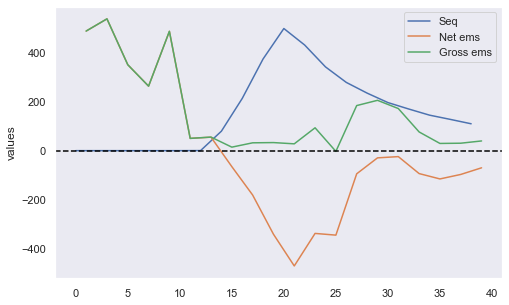

In [41]:
plt.figure(figsize=[8,5])
sns.lineplot(data=all_ems_afolu_waf.loc[all_ems_afolu_waf.Variable == "Carbon Sequestration|Land Use"]["values"], label="Seq")
sns.lineplot(data=all_ems_afolu_waf.loc[all_ems_afolu_waf.Variable == "Emissions|CO2|AFOLU|Land"]["values"], label="Net ems")
sns.lineplot(data=all_ems_afolu_waf.loc[all_ems_afolu_waf.Variable == "Gross Emissions|CO2|AFOLU|Land"]["values"], label="Gross ems")
plt.axhline(0, ls='--', c="black");

# Testing site: downscaling gross emissions, sequestration and net emissions in COD

The following is the function to downscale regional gross emissions and sequestration to country-level. It takes the ratio for a given country and use it to factor the regional emissions/sequestration. It returns a list containing the yearly emissions/sequestration at country-level.

Parameter | Description
:--- | :-------  
`df_weights` | A dataframe containing the downscaling ratio either for emissions or sequestration. The ratio is calculated using calc_downscaling_weights
`country`| A str type. The name of the country as recorded in `df_weights` dataframe, if needed. None by default
`region_ems_prof` | A dataframe containing either regional gross emissions or sequestration

In [44]:
# function to downscale net emission
# it takes country sequestration and emissions, and balances them out
# it returns a list containing country net emissions

def downscale_netemis(country_emis, country_seq):
    calc = country_emis + country_seq
    
    return calc

In [45]:
# downscaling pipeline, the function takes the ratio for a given country and multiply it with the regional sequestration/emissions
# it returns a list containing the yearly sequestration/emissions
def ratio_downscaling(df_weights, region_ems_prof, country=None):
    if country==None:
        region_ems_list = region_ems_prof.loc[:, "values"]*df_weights.values   
        
    else:
        weights_list = df_weights.loc[country].tolist()
        region_ems_list = region_ems_prof.loc[:, "values"]*weights_list
    
    return region_ems_list

In [310]:
def downscaling(ems_ratio_df, seq_ratio_df, ems_afolu, macroreg_name, reg_name):
    template = pd.DataFrame()
    
    reg_ems = ems_afolu.loc[(ems_afolu.Region==macroreg_name) 
                            & (ems_afolu.Variable=="Gross Emissions|CO2|AFOLU|Land")].set_index("years")
    
    ems_country = ratio_downscaling(df_weights=ems_ratio_df, region_ems_prof=reg_ems)
    
    reg_seq = ems_afolu.loc[(ems_afolu.Region==macroreg_name) 
                            & (ems_afolu.Variable=="Carbon Sequestration|Land Use")].set_index("years")
    seq_country = - (ratio_downscaling(df_weights=seq_ratio_df, region_ems_prof=reg_seq))
    
    netemis_country = downscale_netemis(country_emis=ems_country, country_seq=seq_country)
    
    template["Gross Emissions|CO2|AFOLU|Land"] = ems_country
    template["Carbon Sequestration|Land Use"] = seq_country
    template["Emissions|CO2|AFOLU|Land"] = netemis_country
    template.insert(0, "Region", reg_name)
    
    return template.rename_axis("year").reset_index()

In [313]:
cod_cmr_profile_temp = {}
for iso in ems_ratio_waf.keys():
    if iso != "WAF":
        cod_cmr_profile_temp[iso] = downscaling(ems_ratio_df=ems_ratio_waf[iso], seq_ratio_df=seq_ratio_waf[iso],
                                                ems_afolu=all_ems_afolu, macroreg_name="WAF", reg_name=iso)

In [317]:
cod_cmr_profile_temp["COD"].head(2)

year Region  Gross Emissions|CO2|AFOLU|Land  Carbon Sequestration|Land Use  \
0  2005    COD                      134.092317                            0.0   
1  2010    COD                      120.405401                            0.0   

   Emissions|CO2|AFOLU|Land  
0                134.092317  
1                120.405401

In [318]:
cod_cmr_profile_temp["COD"].insert(1, "model", "IMAGE")
cod_cmr_profile_temp["COD"].insert(2, "scenario", "ABC")
cod_cmr_profile_temp["COD"].insert(3, "unit", "DEF")

In [325]:
template_melt = pd.melt(cod_cmr_profile_temp["COD"], id_vars=["year", "model", "scenario", "unit", "Region"],
                           value_vars=["Gross Emissions|CO2|AFOLU|Land", "Carbon Sequestration|Land Use", "Emissions|CO2|AFOLU|Land"],
                           var_name= "variable", value_name="value")

In [329]:
template_melt.to_excel("try_out.xlsx", index=False, merge_cells=False)

In [330]:
read = pyam.IamDataFrame("try_out.xlsx")

pyam.core - INFO: Reading file try_out.xlsx


## Plotting country emissions profile

In [99]:
def country_ems_profile(ems_prof_df, give_name):
    iso = give_name
    
    fig, ax1 = plt.subplots(figsize=[8,5])
    
    # barplot on axis #1 
    x_plot = ems_prof_df.loc[ems_prof_df.iso == iso].index
    subset_iso = ems_prof_df.loc[ems_prof_df.iso == iso]
    
    sns.barplot(data=subset_iso, x=x_plot, y="gross ems", color="mediumseagreen", ax=ax1)
    sns.barplot(data=subset_iso, x=x_plot, y="seq", color="salmon", ax=ax1)
    plt.xticks(np.arange(0, len(x_plot)+1, 2))
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("MtCO2/year", fontsize=12)

    # scatterplot on axis #2
    ax2 = ax1.twiny()
    sns.scatterplot(data=subset_iso, x=x_plot, y='net ems', color="dodgerblue", ax=ax2)
    ax2.axes.get_xaxis().set_visible(False)

    cols_names = ems_prof_df.columns[1:]
    gross_ems = mpatches.Patch(color="mediumseagreen", label=cols_names[0])
    seq = mpatches.Patch(color="salmon", label=cols_names[1])
    net_ems = mpatches.Patch(color="dodgerblue", label=cols_names[2])

    plt.legend(handles=[gross_ems, seq, net_ems])

    plt.title("Emissions profile (downscaled) " + iso)
    plt.axvline(x="2060", color="black")
    
    path_for_jpeg = os.path.join(os.path.expanduser('~'), "Downloads", f"{iso}_emissions_profile.jpeg")
    plt.savefig(f'{path_for_jpeg}')
    plt.close()

In [100]:
# for k in ems_template.iso.unique():
    # country_ems_profile(ems_prof_df=ems_template, give_name=k)

# Test and verify: downscaling all countries within the same regional border at once
steps:
- with dict comprehension, get forest lost and forest sequestration
- with dict comprehension, get ratio for emissions and sequestration
- downscale = reg_ems * ems_ratio; reg_seq * ems_ratio, net ems, store in a dataframe
- pd.DataFrame({Year, Country, Gross Emission, Sequestration, Net Emission}). At every country iteration, append to the empty dataframe row by row
- sum the country emissions/seq to verify the results with regional emissions/seq

## The borders

In [101]:
# Indonesia
indonesia = [360]
indo_reg_ls = [626, 360, 598]
indo_borders = country_region_borders(country_ls=indonesia, region_ls=indo_reg_ls, give_iso2="ID", 
                                      give_iso3="ID_R", give_UN_code="000", give_name="Indonesia Region")

In [102]:
# COD and CMR, Western Africa region
# cod_cmr = [180, 120] 
# waf_ls = [120, 132, 140, 148, 178, 180, 204, 226, 266, 270, 288, 324, 384, 430, 466, 478, 562, 566, 624, 678, 686, 694, 768, 854]
# waf_borders

In [103]:
# Brazil, Brazil region
brazil = 76
regions_2 = regions.drop(columns={"FIPS", "AREA", "POP2005", "REGION", "SUBREGION", "LON", "LAT", "_count_2", "_sum_2"})
brazil_borders = regions_2[regions_2.UN == brazil]

In [104]:
# USA, USA region
usa = 840
usa_borders = regions_2[regions_2.UN == usa]

In [105]:
# Russia Fed, Russia region
russia_fed = [643] 
russia_reg = [51, 31, 268, 643]
russiafed_borders = country_region_borders(country_ls=russia_fed, region_ls=russia_reg,
                                           give_iso2="RR", give_iso3="RU_R", give_UN_code="000", give_name="Russia Region")

In [106]:
# China, China region
china = [156]
china_region = [156, 344, 446, 496, 158]
china_borders = country_region_borders(country_ls=china, region_ls=china_region,
                                       give_iso2="CR", give_iso3="CH_R", give_UN_code="000", give_name="China Region")

In [107]:
canada = 124
canada_borders = regions_2[regions_2.UN == canada]

In [108]:
western_eu27 = [40, 56, 208, 246, 250, 276, 300, 372, 380, 442, 528, 620, 724, 752] # 470 Malta is not present in the data
western_eu_reg = [20, 40, 56, 208, 234, 246, 250, 276, 292, 300, 352, 372, 380, 438, 442, 470, 492, 528, 578, 620, 674, 724, 752, 756, 826, 336]
western_eu27_borders = country_region_borders(country_ls=western_eu27, region_ls=western_eu_reg,
                                              give_iso2="W27", give_iso3="W_EU", give_UN_code="000", give_name="Western EU Region")

In [109]:
central_eu = [100, 191, 196, 203, 233, 348, 428, 440, 616, 642, 703, 705]
central_eu_reg = [8, 70, 100, 191, 196, 203, 233, 348, 428, 440, 807, 616, 642, 891, 703, 705]
central_eu27_borders = country_region_borders(country_ls=central_eu, region_ls=central_eu_reg,
                                              give_iso2="C27", give_iso3="C_EU", give_UN_code="000", give_name="Central EU Region")

## Forest changes

In [110]:
# append country borders differentiated by climate zones
tropical = pd.concat([indo_borders, waf_borders, china_borders, brazil_borders])
temperate_excl_eu = pd.concat([usa_borders, russiafed_borders, canada_borders])
# western_eu27_borders
# central_eu27_borders

In [111]:
# prep kernels
trop_kernel = convert_c(seq_in_c=3.1, saturation=9, phase_in=7, phase_out=4)
temperate_kernel = convert_c(seq_in_c=2.62, saturation=11, phase_in=4, phase_out=5)

In [337]:
# forest changes rate and forest seq in tropical regions
forest_changes_trop = {}
for iso in tropical.ISO3:
    forest_changes_trop[iso] = forest_change_df(input_ncdf=glandcov_19, give_land_type=b'forest                                            ',
                                                reg_boundary=tropical[tropical.ISO3 == iso], 
                                                area_input=area_to_use, seq_rate_ls=trop_kernel)

In [113]:
# forest changes rate and forest seq in temperate regions excl. EU 
forest_changes_temp = {}
for iso in temperate_excl_eu.ISO3:
    forest_changes_temp[iso] = forest_change_df(input_ncdf=glandcov_19, give_land_type=b'forest                                            ',
                                                reg_boundary=temperate_excl_eu[temperate_excl_eu.ISO3 == iso], 
                                                area_input=area_to_use, seq_rate_ls=temperate_kernel)

In [114]:
forest_changes_w_eu27 = {}
for iso in western_eu27_borders.ISO3:
    forest_changes_w_eu27[iso] = forest_change_df(input_ncdf=glandcov_19, give_land_type=b'forest                                            ',
                                                reg_boundary=western_eu27_borders[western_eu27_borders.ISO3 == iso], 
                                                area_input=area_to_use, seq_rate_ls=temperate_kernel)

In [115]:
forest_changes_c_eu27 = {}
for iso in central_eu27_borders.ISO3:
    forest_changes_c_eu27[iso] = forest_change_df(input_ncdf=glandcov_19, give_land_type=b'forest                                            ',
                                                reg_boundary=central_eu27_borders[central_eu27_borders.ISO3 == iso], 
                                                area_input=area_to_use, seq_rate_ls=temperate_kernel)

## Ratio for gross emissions and sequestration

In [116]:
# Indonesia
# gross emissions
ems_ratio_indo = get_ratio(country_forest_ch=forest_changes_trop["IDN"], regional_forest_ch=forest_changes_trop["ID_R"],
                           variable_name="Land area change|Forest|Deforestation Rate")
ems_ratio_indo = ems_ratio_indo.fillna(ems_ratio_indo.median())

# sequestration
seq_ratio_indo = get_ratio(country_forest_ch=forest_changes_trop["IDN"], regional_forest_ch=forest_changes_trop["ID_R"],
                           variable_name="Carbon sequestration|Forest")
seq_ratio_indo = seq_ratio_indo.fillna(seq_ratio_indo.median())

In [117]:
# COD and CMR
# ems_ratio_waf
# seq_ratio_waf

In [118]:
# Russia federation
# gross emissions
ems_ratio_russfed = get_ratio(country_forest_ch=forest_changes_temp["RUS"], regional_forest_ch=forest_changes_temp["RU_R"],
                              variable_name="Land area change|Forest|Deforestation Rate")
ems_ratio_russfed = ems_ratio_russfed.fillna(ems_ratio_russfed.median())

# sequestration
seq_ratio_russfed = get_ratio(country_forest_ch=forest_changes_temp["RUS"], regional_forest_ch=forest_changes_temp["RU_R"],
                              variable_name="Carbon sequestration|Forest")
seq_ratio_russfed = seq_ratio_russfed.fillna(seq_ratio_russfed.median())

In [119]:
# China
# gross emissions
ems_ratio_china = get_ratio(country_forest_ch=forest_changes_trop["CHN"], regional_forest_ch=forest_changes_trop["CH_R"],
                              variable_name="Land area change|Forest|Deforestation Rate")
ems_ratio_china = ems_ratio_china.fillna(ems_ratio_china.median())

# sequestration
seq_ratio_china = get_ratio(country_forest_ch=forest_changes_trop["CHN"], regional_forest_ch=forest_changes_trop["CH_R"],
                              variable_name="Carbon sequestration|Forest")
seq_ratio_china = seq_ratio_china.fillna(seq_ratio_china.median())

In [120]:
# Western EU 27
# gross emissions
ems_ratio_w_eu27 = {}
for iso in forest_changes_w_eu27.keys():
    ems_ratio_w_eu27[iso] = get_ratio(country_forest_ch=forest_changes_w_eu27[iso], regional_forest_ch=forest_changes_w_eu27["W_EU"],
                                    variable_name="Land area change|Forest|Deforestation Rate")
    ems_ratio_w_eu27[iso] = ems_ratio_w_eu27[iso].fillna(ems_ratio_w_eu27[iso].median())

In [121]:
# sequestration
seq_ratio_w_eu27 = {}
for iso in forest_changes_w_eu27.keys():
    seq_ratio_w_eu27[iso] = get_ratio(country_forest_ch=forest_changes_w_eu27[iso], regional_forest_ch=forest_changes_w_eu27["W_EU"],
                                    variable_name="Carbon sequestration|Forest")
    seq_ratio_w_eu27[iso] = seq_ratio_w_eu27[iso].fillna(seq_ratio_w_eu27[iso].median())

In [122]:
# Central EU 27
ems_ratio_c_eu27 = {}
for iso in forest_changes_c_eu27.keys():
    ems_ratio_c_eu27[iso] = get_ratio(country_forest_ch=forest_changes_c_eu27[iso], regional_forest_ch=forest_changes_c_eu27["C_EU"],
                                    variable_name="Land area change|Forest|Deforestation Rate")
    ems_ratio_c_eu27[iso] = ems_ratio_c_eu27[iso].fillna(ems_ratio_c_eu27[iso].median())

In [123]:
# sequestration
seq_ratio_c_eu27 = {}
for iso in forest_changes_c_eu27.keys():
    seq_ratio_c_eu27[iso] = get_ratio(country_forest_ch=forest_changes_c_eu27[iso], regional_forest_ch=forest_changes_c_eu27["C_EU"],
                                    variable_name="Carbon sequestration|Forest")
    seq_ratio_c_eu27[iso] = seq_ratio_c_eu27[iso].fillna(seq_ratio_c_eu27[iso].median())

## Downscaling gross ems, seq, and net ems

In [124]:
# prep regional emissions data
macroregions_ls = ["INDO", "WAF", "BRA", "USA", "RUS", "CHN", "CAN", "WEU", "CEU"]
ems_afolu = timeseries_df(paste_regions=macroregions_ls, paste_vars=["Emissions|CO2|AFOLU|Land", "Carbon Sequestration|Land Use"], df_input_raw=df_tab)

In [125]:
# partitioning the net emissions
all_ems_afolu = gross_emis(df_input_long=ems_afolu, vars_label="Variable",
                           give_seq_vars="Carbon Sequestration|Land Use", give_netemis_vars="Emissions|CO2|AFOLU|Land")

`Indonesia`

In [137]:
indo_profile = downscaling(ems_ratio_df=ems_ratio_indo, seq_ratio_df=seq_ratio_indo, ems_afolu=all_ems_afolu,
                           macroreg_name="INDO", reg_name="IDN")

`Dem Rep of Congo and Cameroon`

In [140]:
cod_cmr_profile = {}
for iso in ems_ratio_waf.keys():
    if iso != "WAF":
        cod_cmr_profile[iso] = downscaling(ems_ratio_df=ems_ratio_waf[iso], seq_ratio_df=seq_ratio_waf[iso],
                                           ems_afolu=all_ems_afolu, macroreg_name="WAF", reg_name=iso)

`Brazil`

In [162]:
brazil_profile = all_ems_afolu.loc[all_ems_afolu.Region=="BRA"].rename(columns={"years":"year"})

`USA`

In [164]:
usa_profile = all_ems_afolu.loc[all_ems_afolu.Region=="USA"].rename(columns={"years":"year"})

`Russia Federation`

In [166]:
russia_profile = downscaling(ems_ratio_df=ems_ratio_russfed, seq_ratio_df=seq_ratio_russfed, ems_afolu=all_ems_afolu,
                           macroreg_name="RUS", reg_name="RUS")

`China`

In [169]:
china_profile = downscaling(ems_ratio_df=ems_ratio_china, seq_ratio_df=seq_ratio_china, ems_afolu=all_ems_afolu,
                           macroreg_name="CHN", reg_name="CHN")

`Canada`

In [238]:
can_profile = all_ems_afolu.loc[all_ems_afolu.Region=="CAN"].rename(columns={"years":"year"})

`Western EU 27`

In [172]:
w_eu27_profile = pd.DataFrame()
for iso in ems_ratio_w_eu27.keys():
    copy = pd.DataFrame()
    if iso != "W_EU":
        copy = downscaling(ems_ratio_df=ems_ratio_w_eu27[iso], seq_ratio_df=seq_ratio_w_eu27[iso],
                           ems_afolu=all_ems_afolu, macroreg_name="WEU", reg_name=iso)
    w_eu27_profile = pd.concat([w_eu27_profile, copy])

In [173]:
w_eu27 = w_eu27_profile.groupby("year").sum()

In [174]:
w_eu27.head(2)

Gross Emissions|CO2|AFOLU|Land  Carbon Sequestration|Land Use  \
year                                                                  
2005                      122.550976                            0.0   
2010                      100.735077                            0.0   

      Emissions|CO2|AFOLU|Land  
year                            
2005                122.550976  
2010                100.735077

`Central EU27`

In [175]:
c_eu27_profile = pd.DataFrame()
for iso in ems_ratio_c_eu27.keys():
    copy = pd.DataFrame()
    if iso != "C_EU":
        copy = downscaling(ems_ratio_df=ems_ratio_c_eu27[iso], seq_ratio_df=seq_ratio_c_eu27[iso],
                           ems_afolu=all_ems_afolu, macroreg_name="CEU", reg_name=iso)
    c_eu27_profile = pd.concat([c_eu27_profile, copy])

In [176]:
c_eu27 = c_eu27_profile.groupby("year").sum()

In [177]:
c_eu27.head(2)

Gross Emissions|CO2|AFOLU|Land  Carbon Sequestration|Land Use  \
year                                                                  
2005                       53.248974                            0.0   
2010                       40.997976                            0.0   

      Emissions|CO2|AFOLU|Land  
year                            
2005                 53.248974  
2010                 40.997976

`EU27`

In [178]:
eu27_profile = w_eu27 + c_eu27
eu27_profile.insert(0, "Region", "EU27")

In [179]:
eu27_profile.head(2)

Region  Gross Emissions|CO2|AFOLU|Land  Carbon Sequestration|Land Use  \
year                                                                         
2005   EU27                      175.799950                            0.0   
2010   EU27                      141.733053                            0.0   

      Emissions|CO2|AFOLU|Land  
year                            
2005                175.799950  
2010                141.733053

# Prep data tables

## Forest changes : country level

In [513]:
forest_changes_trop["COD"].index

Int64Index([2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055,
            2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100],
           dtype='int64')

In [339]:
test = pd.to_datetime(forest_changes_trop["COD"].index, format='%Y').to_period("Y")

In [340]:
test

PeriodIndex(['2005', '2010', '2015', '2020', '2025', '2030', '2035', '2040',
             '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080',
             '2085', '2090', '2095', '2100'],
            dtype='period[A-DEC]')

In [533]:
template = pd.DataFrame()
for iso in forest_changes_trop.keys():
    if iso != "ID_R" and iso != "WAF" and iso != "CH_R":
        t = forest_changes_trop[iso].iloc[:,:3].rename_axis("year").reset_index()
        
        base = pd.melt(t,
                       id_vars="year",
                       value_vars=["Land area change|Forest|Afforestation and Reforestation Rate",
                                   "Land area change|Forest|Deforestation Rate", 
                                   "Land area change|Forest|Net Rate of Forest Change"],
                       var_name="Variable", value_name="values")
        base.insert(1, "Region", iso)
    template = pd.concat([template, base])

In [534]:
for iso in forest_changes_temp.keys():
    if iso != "RU_R":
        t = forest_changes_temp[iso].iloc[:,:3].rename_axis("year").reset_index()
        base = pd.melt(t,
                       id_vars="year",
                       value_vars=["Land area change|Forest|Afforestation and Reforestation Rate",
                                   "Land area change|Forest|Deforestation Rate", 
                                   "Land area change|Forest|Net Rate of Forest Change"],
                       var_name="Variable", value_name="values")
        base.insert(1, "Region", iso)
    template = pd.concat([template, base])

In [535]:
# WEU 27
w_eu_27_t = pd.DataFrame()
for iso in forest_changes_w_eu27.keys():
    if iso != "W_EU":
        t = forest_changes_w_eu27[iso].iloc[:,:3].rename_axis("year").reset_index()
        base = pd.melt(t,
                       id_vars="year",
                       value_vars=["Land area change|Forest|Afforestation and Reforestation Rate",
                                   "Land area change|Forest|Deforestation Rate", 
                                   "Land area change|Forest|Net Rate of Forest Change"],
                       var_name="Variable", value_name="values")
        base.insert(1, "Region", iso)
    w_eu_27_t = pd.concat([w_eu_27_t, base])

In [536]:
w_eu27_forest = w_eu_27_t.groupby(["year", "Variable"]).sum()

In [537]:
# CEU 27
c_eu_27_t = pd.DataFrame()
for iso in forest_changes_c_eu27.keys():
    if iso != "C_EU":
        t = forest_changes_c_eu27[iso].iloc[:,:3].rename_axis("year").reset_index()
        base = pd.melt(t,
                       id_vars="year",
                       value_vars=["Land area change|Forest|Afforestation and Reforestation Rate",
                                   "Land area change|Forest|Deforestation Rate", 
                                   "Land area change|Forest|Net Rate of Forest Change"],
                       var_name="Variable", value_name="values")
        base.insert(1, "Region", iso)
    c_eu_27_t = pd.concat([c_eu_27_t, base])

In [538]:
c_eu27_forest = c_eu_27_t.groupby(["year", "Variable"]).sum()

In [539]:
# EU27
eu27_forest = w_eu27_forest + c_eu27_forest

In [540]:
eu27_forest = pd.DataFrame(eu27_forest.to_records())
eu27_forest.insert(1, "Region", "EU27")

In [541]:
# all countries
template_full = pd.concat([template, eu27_forest])

In [542]:
# insert necessary information
template_full.insert(2, "Model", "IMAGE")
template_full.insert(3, "Scenario", "SSP1_SPA0_19I_LIRE_LB")
template_full.insert(5, "Unit", "million ha/yr")

In [543]:
template_full.head(2)

year Region  Model               Scenario  \
0  2005    IDN  IMAGE  SSP1_SPA0_19I_LIRE_LB   
1  2010    IDN  IMAGE  SSP1_SPA0_19I_LIRE_LB   

                                            Variable           Unit  \
0  Land area change|Forest|Afforestation and Refo...  million ha/yr   
1  Land area change|Forest|Afforestation and Refo...  million ha/yr   

         values  
0  8.269847e-03  
1  1.170062e-08

In [545]:
template_full["year"] = template_full["year"].astype("str")

In [548]:
# convert year from int to datetime
template_full["year"] = pd.to_datetime(template_full["year"], format="%Y")

In [554]:
template_full["year"] = template_full["year"].dt.to_period('Y')

In [408]:
template_full["year"] = pd.DatetimeIndex(template_full["year"]).year

In [556]:
template_full.to_excel("withdateperiod.xlsx", index=False, merge_cells=False)

In [420]:
template_melt.dtypes

year         object
model        object
scenario     object
unit         object
Region       object
variable     object
value       float64
dtype: object

In [558]:
try_read = pyam.IamDataFrame("try_out.xlsx")

pyam.core - INFO: Reading file try_out.xlsx


In [559]:
try_read

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : IMAGE (1)
 * scenario : ABC (1)
Timeseries data coordinates:
   region   : COD (1)
   variable : Carbon Sequestration|Land Use, ... (3)
   unit     : DEF (1)
   year     : 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, ... 2100 (20)
Meta indicators:
   exclude (bool) False (1)

## Emissions profile : country level

In [239]:
no_ds = pd.concat([brazil_profile, usa_profile, can_profile]).reset_index(drop=True)

In [210]:
others = pd.concat([russia_profile, china_profile, eu27_profile, indo_profile])

In [213]:
others_melt = pd.melt(others,
                     id_vars=["year","Region"],
                     value_vars=["Gross Emissions|CO2|AFOLU|Land",
                                "Carbon Sequestration|Land Use", 
                                "Emissions|CO2|AFOLU|Land"],
                     var_name="Variable", value_name="values")

In [219]:
# cod_cmr
# cod_cmr = pd.DataFrame()
for iso in cod_cmr_profile.keys():
    base = pd.melt(cod_cmr_profile[iso],
                   id_vars=["year", "Region"],
                   value_vars=["Gross Emissions|CO2|AFOLU|Land",
                               "Carbon Sequestration|Land Use", 
                               "Emissions|CO2|AFOLU|Land"],
                   var_name="Variable", value_name="values")
    others_melt = pd.concat([others_melt, base])

In [221]:
others_melt.head(2)

year Region                        Variable      values
0  2005    RUS  Gross Emissions|CO2|AFOLU|Land  151.988793
1  2010    RUS  Gross Emissions|CO2|AFOLU|Land  187.951612

In [222]:
# insert necessary information
others_melt.insert(2, "Model", "IMAGE")
others_melt.insert(3, "Scenario", "SSP1_SPA0_19I_LIRE_LB")
others_melt.insert(5, "Unit", "Mt CO2/yr")

# Saving data tables

In [256]:
# read = pyam.IamDataFrame("a.xlsx")

In [280]:
table_full = pd.concat([template_full, others_melt, no_ds])

In [262]:
table_full['year'] =  pd.to_datetime(table_full['year'])

In [ ]:
df['year'] = pd.DatetimeIndex(df['birth_date']).year

In [ ]:
df['month_year'] = pd.to_datetime(df['birth_date']).dt.to_period('M')

In [291]:
no_ds.year

0      2005
1      2005
2      2005
3      2010
4      2010
       ... 
175    2095
176    2095
177    2100
178    2100
179    2100
Name: year, Length: 180, dtype: period[A-DEC]

In [290]:
no_ds['year'] = pd.to_datetime(no_ds['year']).dt.to_period("Y")

In [ ]:
df['DataFrame Column'] = pd.to_datetime(df['DataFrame Column'], format=specify your format)

In [282]:
table_full

year Region  Model               Scenario  \
0    1970    IDN  IMAGE  SSP1_SPA0_19I_LIRE_LB   
1    1970    IDN  IMAGE  SSP1_SPA0_19I_LIRE_LB   
2    1970    IDN  IMAGE  SSP1_SPA0_19I_LIRE_LB   
3    1970    IDN  IMAGE  SSP1_SPA0_19I_LIRE_LB   
4    1970    IDN  IMAGE  SSP1_SPA0_19I_LIRE_LB   
..    ...    ...    ...                    ...   
175  2095    CAN  IMAGE  SSP1_SPA0_19I_LIRE_LB   
176  2095    CAN  IMAGE  SSP1_SPA0_19I_LIRE_LB   
177  2100    CAN  IMAGE  SSP1_SPA0_19I_LIRE_LB   
178  2100    CAN  IMAGE  SSP1_SPA0_19I_LIRE_LB   
179  2100    CAN  IMAGE  SSP1_SPA0_19I_LIRE_LB   

                                              Variable           Unit  \
0    Land area change|Forest|Afforestation and Refo...  million ha/yr   
1    Land area change|Forest|Afforestation and Refo...  million ha/yr   
2    Land area change|Forest|Afforestation and Refo...  million ha/yr   
3    Land area change|Forest|Afforestation and Refo...  million ha/yr   
4    Land area change|Forest|Afforestation and Refo...  million ha/yr   
..                                                 ...            ...   
175                      Carbon Sequestration|Land Use      Mt CO2/yr   
176                           Emissions|CO2|AFOLU|Land      Mt CO2/yr   
177                     Gross Emissions|CO2|AFOLU|Land      Mt CO2/yr   
178                           Emissions|CO2|AFOLU|Land      Mt CO2/yr   
179                      Carbon Sequestration|Land Use      Mt CO2/yr   

           values  
0    8.269847e-03  
1    1.170062e-08  
2    3.870445e-08  
3    3.215907e-02  
4    7.772851e-02  
..            ...  
175  3.874925e+01  
176 -1.432713e+01  
177  2.087833e+01  
178 -7.896493e+00  
179  2.877483e+01  

[1320 rows x 7 columns]

In [244]:
table_full.to_excel("temp_export_ver4.xlsx", index=False, merge_cells=False)

In [245]:
read = pyam.IamDataFrame("def.xlsx")

pyam.core - INFO: Reading file temp_export_ver4.xlsx


ValueError: Invalid time format, must be either years or `datetime`!

In [365]:
read_pyam.timeseries().to_excel("IMAGE_LULUCF_ver4_20220411.xlsx", merge_cells=False)

`Macro-region`

In [332]:
macro = pd.concat([forest_changes_indo["IND"], forest_changes_waf["WAF"], forest_changes_bra,
                forest_changes_usa, forest_changes_russfed["RU_R"], forest_changes_china["CHN_R"], forest_changes_canada,
                forest_changes_w_eu27["W_EU"], forest_changes_c_eu27["C_EU"]])

In [368]:
macro_melt = pd.melt(macro,
                     id_vars=["Year", 'Model', 'Scenario', 'Unit', 'Macro-region', 'Region'], 
                     value_vars=['Land area change|Forest|Afforestation and Reforestation',
                                'Land area change|Forest|Deforestation',
                                'Land area change|Forest|Net Area Change'],
                     var_name="Variable", value_name="Value")

In [369]:
macro_melt.to_excel("macro_forest_changes.xlsx", index=False, merge_cells=False)

In [370]:
read_pyam = pyam.IamDataFrame(data='macro_forest_changes.xlsx')

pyam.core - INFO: Reading file macro_forest_changes.xlsx


In [371]:
read_pyam.timeseries().to_excel("Macroregion_forest_changes.xlsx", merge_cells=False)